# Определение перспективного тарифа для телеком компании

Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

### Вступление
Цель нашей работы - сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше..

Для достижения задач нам нужно получить выгрузку архива из файлов, проанализировать их, найти пропущенные значения, выявить их природу, по возможности обоснованно заполнить, а также удалить дубликаты и привести данные к тому типу, с которым будет нагляднее работать. После предобработки данных необходимо описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения. После чего мы сможем 

Описание данных:

##### 1. Таблица users (информация о пользователях):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

##### 2. Таблица calls (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

##### 3. Таблица messages (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

##### 4. Таблица internet (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

##### 5. Таблица tariffs (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взыматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Открыть файлы с данными и изучить общую информацию. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [3]:
calls_table = pd.read_csv('/datasets/calls.csv')
calls_table.info()
calls_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
internet_table = pd.read_csv('/datasets/internet.csv')
internet_table.info()
internet_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
messages_table = pd.read_csv('/datasets/messages.csv')
messages_table.info()
messages_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
tariffs_table = pd.read_csv('/datasets/tariffs.csv')
tariffs_table.info()
tariffs_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
users_table = pd.read_csv('/datasets/users.csv')
users_table.info()
users_table.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


### Вывод

Перед нами 5 таблиц с данными по тарифам, звонкам, пользователям, сообщениям и интернету. Сразу видим необходимость перевода даты в формат datetime64, с которым будет удобнее оперировать. Пропущенные значения обнаружились только в указании даты прекращения пользования тарифом. Никаких противоречий в этом нет. Пропущенное значение лишь указывает на то, что тариф на момент выгрузки данных был активен.
Большое количество продолжительностей звонков в датафрейме calls_table равно нулю. Примем во внимание, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Также тарифицируются целые минуты, поэтому для анализа мы можем округлить фактическое время в большую сторону, предварительно прибавив ко времени 0,001 мин., чтобы избежать значения, равного нулю.
Все пользователи подключились в 2018 году, а значит кто-то это сделал в январе, а кто-то мог в ноябре или декабре. Эти данные будем учитывать в столбцах "first_month" и "last_month", добавив их ту же таблицу.

### Шаг 2. Предобработка данных

In [8]:
# Округлим время звонков в большую сторону.
calls_table['duration'] = np.ceil(calls_table['duration'] + 0.001).astype('int')

# преобразуем строку с датой в тип даты
calls_table['call_date'] = pd.to_datetime(calls_table['call_date'], format='%Y-%m-%d')
internet_table['session_date'] = pd.to_datetime(internet_table['session_date'], format='%Y-%m-%d')
messages_table['message_date'] = pd.to_datetime(messages_table['message_date'], format='%Y-%m-%d')
users_table['churn_date'] = pd.to_datetime(users_table['churn_date'], format='%Y-%m-%d')
users_table['reg_date'] = pd.to_datetime(users_table['reg_date'], format='%Y-%m-%d')

# тут же добавим столбцы первого и последнего месяцев
# если последний месяц пропущен, то для нас это будет декабрь
users_table['first_month'] = users_table['reg_date'].dt.month
users_table['last_month'] = users_table['churn_date'].dt.month.fillna(12).astype('int')

In [9]:
calls_table.info()
internet_table.info()
messages_table.info()
users_table.info()
tariffs_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
<class 'panda

Теперь данные приведены к нужному типу.

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [10]:
# количество сделанных звонков и израсходованных минут разговора по месяцам
calls_table['month'] = calls_table['call_date'].dt.month
calls_stat_table = calls_table.pivot_table(index='user_id', columns='month', values='duration', aggfunc=('count', 'sum'))
calls_stat_table = calls_stat_table.fillna(0).astype('int')
calls_stat_table

count                                        ...  sum                 \
month      1   2   3   4   5   6   7   8    9    10  ...   3    4    5    6    
user_id                                              ...                       
1000        0   0   0   0  22  43  47  52   58   57  ...    0    0  164  187   
1001        0   0   0   0   0   0   0   0    0    0  ...    0    0    0    0   
1002        0   0   0   0   0  15  26  42   36   33  ...    0    0    0  118   
1003        0   0   0   0   0   0   0  55  134  108  ...    0    0    0    0   
1004        0   0   0   0   9  31  22  19   26   29  ...    0    0   37  177   
...       ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
1495        0   0   0   0   0   0   0  17  112  152  ...    0    0    0    0   
1496        7  77  79  67  63  74  73  88   68   72  ...  569  538  498  572   
1497        0   0   0   0   0   0   0   0    0   66  ...    0    0    0    0   
1498        0   0   0   0   0   0  23  57   59   41  ...    0    0    0    0   
1499        0   0   0   0   0   0   0   0    9   68  ...    0    0    0    0   

                                         
month     7    8    9     10   11    12  
user_id                                  
1000     346  419  479   363  344   341  
1001       0    0    0     0  444   430  
1002     219  296  218   221  250   242  
1003       0  392  990   867  844   822  
1004     137  138  125   154  122   136  
...      ...  ...  ...   ...  ...   ...  
1495       0   96  833  1057  972  1069  
1496     592  553  496   467  677   533  
1497       0    0    0   506  387   558  
1498     178  414  477   259    0     0  
1499       0    0   71   474  624   505  

[492 rows x 24 columns]

In [11]:
# количество отправленных сообщений по месяцам
messages_table['month'] = messages_table['message_date'].dt.month
messages_stat_table = messages_table.pivot_table(index='user_id', columns='month', values='id', aggfunc='count')
messages_stat_table = messages_stat_table.fillna(0).astype('int')
messages_stat_table

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,22,60,75,81,57,73,58,70
1002,0,0,0,0,0,4,11,13,4,10,16,12
1003,0,0,0,0,0,0,0,37,91,83,94,75
1004,0,0,0,0,95,134,181,151,146,165,158,162
1005,7,38,56,41,42,47,56,64,52,44,51,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,13,82,82,79,84
1496,9,45,46,49,40,35,42,41,29,35,46,51
1497,0,0,0,0,0,0,0,0,0,20,14,17


In [12]:
# объем израсходованного интернет-трафика по месяцам
internet_table['month'] = internet_table['session_date'].dt.month
internet_stat_table = internet_table.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum')
internet_stat_table = internet_stat_table.fillna(0)
internet_stat_table

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.00,0.00,0.0,0.00,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61
1001,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18429.34,14036.66
1002,0.00,0.00,0.0,0.00,0.00,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73
1003,0.00,0.00,0.0,0.00,0.00,0.00,0.00,8565.21,12468.87,14768.14,11356.89,10121.53
1004,0.00,0.00,0.0,0.00,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2614.07,33067.62,29363.00,38939.11,23426.76
1496,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15
1497,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,11500.29,14156.08,19918.60


In [13]:
# если разница между использованными ресурсами и бесплатным лимитом меньше нуля, то перерасход = 0
def to_zero (num):
    if num < 0:
        num = 0
    return num

# вычтем бесплатный лимит из суммарного количества интернет-трафика
internet_stat_table = internet_stat_table.merge(users_table[['user_id', 'tariff']], on='user_id')
internet_stat_table.rename(columns={'tariff': 'tariff_name'}, inplace=True)
internet_stat_table = internet_stat_table.merge(tariffs_table, on='tariff_name')
for i in range(1, 13):
    internet_stat_table[i] -= internet_stat_table['mg_per_month_included']
    internet_stat_table[i] = internet_stat_table[i].apply(to_zero)
    # остаток умножим на значение из тарифного плана
    internet_stat_table[i] = np.ceil(internet_stat_table[i] / 1000) * internet_stat_table['rub_per_gb']
internet_stat_table = internet_stat_table.sort_values(by='user_id').reset_index(drop=True).set_index('user_id')
internet_stat_table

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
user_id,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,30720,3000,1950,150,1,1
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,800.0,0.0,smart,50,15360,500,550,200,3,3
1002,0.0,0.0,0.0,0.0,0.0,0.0,600.0,1000.0,400.0,0.0,800.0,600.0,smart,50,15360,500,550,200,3,3
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,30720,3000,1950,150,1,1
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450.0,0.0,1350.0,0.0,ultra,1000,30720,3000,1950,150,1,1
1496,0.0,2800.0,2000.0,1200.0,1800.0,1000.0,2000.0,1800.0,2400.0,2600.0,2000.0,1200.0,smart,50,15360,500,550,200,3,3
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,smart,50,15360,500,550,200,3,3


In [14]:
# сообщений...
messages_stat_table = messages_stat_table.merge(users_table[['user_id', 'tariff']], on='user_id')
messages_stat_table.rename(columns={'tariff': 'tariff_name'}, inplace=True)
messages_stat_table = messages_stat_table.merge(tariffs_table, on='tariff_name')
for i in range(1, 13):
    messages_stat_table[i] -= messages_stat_table['messages_included']
    messages_stat_table[i] = messages_stat_table[i].apply(to_zero) #.astype('int')
    # остаток умножим на значение из тарифного плана
    messages_stat_table[i] *= messages_stat_table['rub_per_message']
messages_stat_table = messages_stat_table.sort_values(by='user_id').reset_index(drop=True).set_index('user_id')
messages_stat_table

,1,2,3,4,5,6,7,8,9,10,11,12,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
user_id,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0,ultra,1000,30720,3000,1950,150,1,1
1002,0,0,0,0,0,0,0,0,0,0,0,0,smart,50,15360,500,550,200,3,3
1003,0,0,0,0,0,0,0,0,0,0,0,0,ultra,1000,30720,3000,1950,150,1,1
1004,0,0,0,0,0,0,0,0,0,0,0,0,ultra,1000,30720,3000,1950,150,1,1
1005,0,0,18,0,0,0,18,42,6,0,3,12,smart,50,15360,500,550,200,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,0,0,0,0,0,ultra,1000,30720,3000,1950,150,1,1
1496,0,0,0,0,0,0,0,0,0,0,0,3,smart,50,15360,500,550,200,3,3
1497,0,0,0,0,0,0,0,0,0,0,0,0,smart,50,15360,500,550,200,3,3


In [15]:
# ... и звонков.
calls_stat_table = calls_stat_table.merge(users_table[['user_id', 'tariff']], on='user_id')
calls_stat_table.rename(columns={'tariff': 'tariff_name'}, inplace=True)
calls_stat_table = calls_stat_table.merge(tariffs_table, on='tariff_name')
for i in range(1, 13):
    calls_stat_table['sum', i] -= calls_stat_table['minutes_included']
    calls_stat_table['sum', i] = calls_stat_table['sum', i].apply(to_zero)
    # остаток умножим на значение из тарифного плана
    calls_stat_table['sum', i] *= calls_stat_table['rub_per_minute']
calls_stat_table = calls_stat_table.sort_values(by='user_id').reset_index(drop=True).set_index('user_id')
calls_stat_table

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 6)","(count, 7)","(count, 8)","(count, 9)","(count, 10)",...,"(sum, 11)","(sum, 12)",tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
user_id,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,22,43,47,52,58,57,...,0,0,ultra,1000,30720,3000,1950,150,1,1
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,smart,50,15360,500,550,200,3,3
1002,0,0,0,0,0,15,26,42,36,33,...,0,0,smart,50,15360,500,550,200,3,3
1003,0,0,0,0,0,0,0,55,134,108,...,0,0,ultra,1000,30720,3000,1950,150,1,1
1004,0,0,0,0,9,31,22,19,26,29,...,0,0,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,0,0,0,0,0,0,17,112,152,...,0,0,ultra,1000,30720,3000,1950,150,1,1
1496,7,77,79,67,63,74,73,88,68,72,...,531,99,smart,50,15360,500,550,200,3,3
1497,0,0,0,0,0,0,0,0,0,66,...,0,174,smart,50,15360,500,550,200,3,3


In [16]:
# Функция возвращает абонентскую плату в период подключения абонента
def abon_fee(row):
    if row['first_month'] <= i <= row['last_month']:
        return row['rub_monthly_fee']
    else:
        return 0

# создаем результирующую таблицу по доходам с абонентов
result_table = users_table[['user_id', 'first_month', 'last_month', 'tariff']].set_index('user_id').reset_index()
temp = tariffs_table[['tariff_name', 'rub_monthly_fee']]
temp.rename(columns={'tariff_name': 'tariff'}, inplace=True)
result_table = result_table.merge(temp, on='tariff').sort_values(by='user_id').set_index('user_id')
for i in range(1, 13):
    # заполняем таблицу оплат либо абонентской платой, либо нулями
    result_table[i] = result_table.apply(abon_fee, axis=1)
    # добавляем к значениям оплаты услуг, которые не были включены в абонентскую плату
    result_table[i] += (calls_stat_table['sum', i].fillna(0) + messages_stat_table[i].fillna(0) + internet_stat_table[i].fillna(0)).fillna(0)
result_table

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,first_month,last_month,tariff,rub_monthly_fee,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,,,,,
1000,5,12,ultra,1950,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1001,11,12,smart,550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,550.0
1002,6,12,smart,550,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1550.0,950.0,550.0,1350.0,1150.0
1003,8,12,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
1004,5,12,ultra,1950,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,8,12,ultra,1950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2400.0,1950.0,3300.0,1950.0
1496,1,12,smart,550,550.0,3671.0,2757.0,1864.0,2350.0,1766.0,2826.0,2509.0,2950.0,3150.0,3081.0,1852.0
1497,10,12,smart,550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,550.0,1724.0


### Вывод:
Данные подготовлены к дальнейшему анализу.

### Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки.


Для тарифа ultra
Звонки: count     149.000000
mean      538.860125
std       291.787941
min         0.000000
25%       330.375000
50%       529.666667
75%       767.833333
max      1210.909091
Name: duration, dtype: float64
Дисперсия равна: 85140.20250010614

Интернет:
 count      149.000000
mean     19443.271135
std       8436.860129
min          0.000000
25%      13550.778182
50%      18685.458000
75%      25801.390000
max      38463.570000
Name: mb_used, dtype: float64
Дисперсия равна: 71180608.84282224

Сообщения:
 count    149.000000
mean      53.668121
std       46.420854
min        0.000000
25%       14.000000
50%       45.000000
75%       84.000000
max      192.000000
Name: messages, dtype: float64
Дисперсия равна: 2154.8956829312533

Для тарифа smart
Звонки: count    351.000000
mean     430.369505
std      150.530432
min        0.000000
25%      325.575758
50%      437.000000
75%      531.277778
max      914.500000
Name: duration, dtype: float64
Дисперсия равна: 22659.4110783

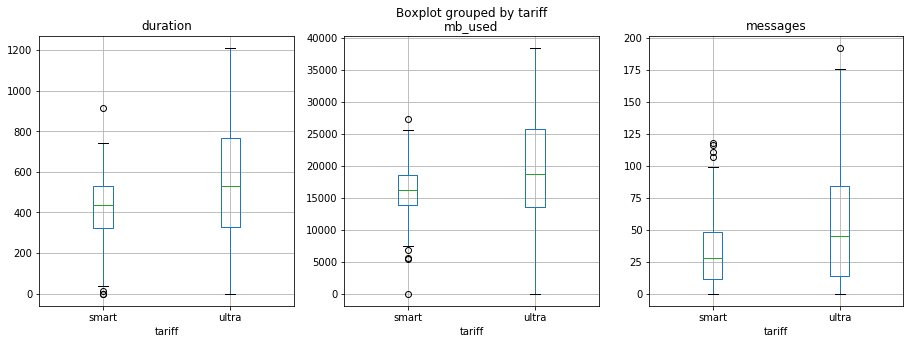

In [17]:
# Функция возвращает сумму оплат абонента за весь год
def year_sum(row):
    sum = 0
    for i in range(1, 13):
        sum += row[i]
    return sum

# создадим снова сводные таблицы
calls_stat_table = calls_table.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum').fillna(0)
messages_stat_table = messages_table.pivot_table(index='user_id', columns='month', values='id', aggfunc='count').fillna(0)
internet_stat_table = internet_table.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum').fillna(0)

# Посчитаем показатели пользования услуг и выручку за год
calls_stat_table['year_calls'] = calls_stat_table.apply(year_sum, axis=1)
messages_stat_table['year_messages'] = messages_stat_table.apply(year_sum, axis=1)
internet_stat_table['year_internet'] = internet_stat_table.apply(year_sum, axis=1)
result_table['year_payment'] = result_table.apply(year_sum, axis = 1)
    
# создадим результирующую таблицу, где у каждого абонента будут среднемесячные показатели потреблённых услуг и средняя выручка
# с учетом количества месяцев, когда абонент был подключен к тарифу
result = users_table[['user_id', 'city', 'tariff', 'first_month', 'last_month']].set_index('user_id')
result = result.merge(calls_stat_table[['year_calls']], on='user_id', how='left')\
    .merge(messages_stat_table[['year_messages']], on='user_id', how='left')\
    .merge(internet_stat_table[['year_internet']], on='user_id', how='left')\
    .merge(result_table[['year_payment']], on='user_id', how='left')\
    .fillna(0)
result['year_calls'] /= (result['last_month'] - result['first_month'] + 1)
result['year_messages'] /= (result['last_month'] - result['first_month'] + 1)
result['year_internet'] /= (result['last_month'] - result['first_month'] + 1)
result['year_payment'] /= (result['last_month'] - result['first_month'] + 1)
result = result.rename(columns={'year_calls': 'duration', 'year_messages': 'messages', 'year_internet': 'mb_used', 'year_payment': 'month_fee'})

# построим диаграммы размаха по данным для каждого тарифа
plt.subplots(figsize=(15, 5))
result.boxplot('duration', by='tariff', ax = plt.subplot(1, 3, 1))
result.boxplot('mb_used', by='tariff', ax = plt.subplot(1, 3, 2))
plot = result.boxplot('messages', by='tariff', ax = plt.subplot(1, 3, 3))

# выведем разбросы значений, средние показатели датасетов
for i in result['tariff'].unique():
    print('\nДля тарифа', i)
    print('Звонки:', result[result['tariff'] == i]['duration'].describe())
    print('Дисперсия равна:', np.var(result[result['tariff'] == i]['duration'], ddof=1))
    print('\nИнтернет:\n', result[result['tariff'] == i]['mb_used'].describe())
    print('Дисперсия равна:', np.var(result[result['tariff'] == i]['mb_used'], ddof=1))
    print('\nСообщения:\n', result[result['tariff'] == i]['messages'].describe())
    print('Дисперсия равна:', np.var(result[result['tariff'] == i]['messages'], ddof=1))

Средняя выручка всех абонентов тарифа ultra: 302758.1006493507
Средняя выручка всех абонентов тарифа smart: 433846.15793650795


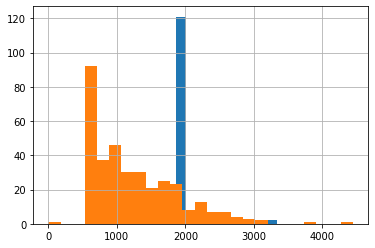

In [18]:
# построим гистограммы выручек в зависимости от тарифа
sample1 = result[result['tariff'] == 'ultra']['month_fee']
sample2 = result[result['tariff'] == 'smart']['month_fee']
sample1.hist(bins=25)
sample2.hist(bins=25)

print('Средняя выручка всех абонентов тарифа ultra:', sample1.sum())
print('Средняя выручка всех абонентов тарифа smart:', sample2.sum())

Пиковые значения наблюдаем в области размера абонентской платы. То есть большинство абонентов вписываются в количество услуг, включённых в абонентскую плату.

### Вывод
Во всех трёх случаях датасеты тарифа Ультра скошены вверх. Абоненты этого тарифа значительно больше пользуются предоставляемыми услугами, а значит заинтересованы в таком количестве, то есть подключение к данному тарифу благоприятно отражается как на абоненте, так и выручке, которую получает оператор связи. Однако абонентов тарифа Смарт больше количественно (почти в 2,5 раза), а часть из них (почти половина) использует те или иные услуги на уровне абонентов тарифа Ультра. Было бы неплохо им предложить перевестись именно на этот тариф - выручка могла бы вырасти за счет абонентской платы. Хотя суммарно пользователи тарифа Смарт приносят средний ежемесячный доход почти на 50% больше, чем пользователи тарифа Ультра.

### Шаг 4. Проверка гипотез

- Первая гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается:

Для начала выясним, равная ли дисперсия у двух выборок

In [19]:
for i in result['tariff'].unique():
    print('Дисперсия для тарифа', i, 'равна:', np.var(result[result['tariff'] == i]['month_fee'], ddof=1))

Дисперсия для тарифа ultra равна: 93673.86753291247
Дисперсия для тарифа smart равна: 428409.2397380718


Поскольку нет, значение параметра equal_var = False.

Критическому уровню статистической зависимости дадим значение 5%
Наша нулевая гипотеза очевидна: средняя выручка пользователей двух тарифов не различается. Альтернативная: различаются (одна больше или меньше другой).

In [20]:
sample1 = result[result['tariff'] == 'ultra']['month_fee']
sample2 = result[result['tariff'] == 'smart']['month_fee']
alpha = 0.05

results = st.ttest_ind(sample1, sample2, equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, средняя выручка различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, средняя выручка не различается")

p-значение: 1.7783532582023064e-58
Отвергаем нулевую гипотезу, средняя выручка различается


- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Критическому уровню статистической зависимости дадим значение 5%
Наша нулевая гипотеза: средняя выручка пользователей из Москвы и пользователей других регионов не различается. Альтернативная: различаются (одна больше или меньше другой).

Опять же выясним, равная ли дисперсия у двух выборок.

In [21]:
sample1 = result[result['city'] == 'Москва']['month_fee']
sample2 = result[result['city'] != 'Москва']['month_fee']
alpha = 0.05
print('Дисперсия пользователей из Москвы равна:', np.var(sample1, ddof=1))
print('Дисперсия пользователей из других регионов равна:', np.var(sample2, ddof=1))


Дисперсия пользователей из Москвы равна: 451214.9612622669
Дисперсия пользователей из других регионов равна: 463319.71321736084


Выборки взяты из схожих по параметрам совокупностей (в любом городе есть оба тарифа с одинаковыми ценами и набором услуг), дисперсии отличаются незначительно, будем считать, что они равны и значение параметра equal_var = True.

In [22]:
results = st.ttest_ind(sample1, sample2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, средняя выручка различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, средняя выручка не различается")

p-значение: 0.28910557040575685
Не получилось отвергнуть нулевую гипотезу, средняя выручка не различается


### Вывод:
Мы проверили 2 гипотезы: о том, что средняя выручка отличается в зависимости от тарифа, и о том, что средняя выручка отличается для пользователей из Москвы и пользователей других регионов.

Первая гипотеза была подтверждена - средняя выручка с пользователей разных тарифов вероятнее всего различается.

Вторая гипотеза была опровергнута - средняя выручка с пользователей из Москвы вероятнее всего не отличается от выручки с пользователей других регионов.


### Шаг 5. Общий вывод

Исследование данных за 2018 год компании "Мегалайн" показало, что пользователей тарифа Смарт почти в 2,5 раза больше, чем пользователей тарифа Ультра, а средний ежемесячный доход с тарифа Смарт всего почти в 1,5 раза больше. Часть пользователей тарифа Смарт потребляют услуги примерно на одном уровне с частью пользователей тарифа Ультра.

Мы провели ряд гипотез, чтобы выявить разницу в потреблении услуг пользователями: а) разных тарифных планов; б) разных населённых пунктов (Москва и все другие).
Проверка гипотез показала, что вероятнее всего средняя выручка с пользователей разных тарифов различается, а средняя выручка с жителей Москвы и других регионов на одном уровне. В обоих случаях мы воспользовались понятием гипотезы о равенстве средних двух совокупностей. При этом:

а) в качестве нулевой гипотезы мы посчитали, что средняя выручка пользователей двух тарифов не различается, в качестве альтернативной - что выручка различается (одна больше или меньше другой). По результату статистического анализа мы отвергли нулевую гипотезу, тем самым подтвердили нашу изначальную. И действительно - минимальный размер месячной оплаты услуг - абонентская плата, и если пользователь понимает, что тратит на связь существенно больше заложенного в абонентскую плату своего тарифа, он переходит на другой тариф, тем самым оптимизирует свои расходы.

б) в качестве нулевой гипотезы мы посчитали, что средняя выручка пользователей Москвы и других регионов не различается, в качестве альтернативной - что выручка различается (одна больше или меньше другой). По результату статистического анализа мы не отвергли нулевую гипотезу, тем самым отвергли нашу изначальную. И действительно - независимо от региона при одинаковых условиях тарифных планов абоненты примерно одинаково общаются, пишут сообщения и пользуются интернетом, то есть тратят на связь в среднем везде одинаково. Выручка будет расти только за счет увеличения количества абонентов.

Чтобы добиться данных выводов, была проведена работа по анализу входных данных, приведению их к нужному типу для наиболее детальной обработки, а также наглядное отображение полученных результатов в виде диаграмм размаха и гистограм.

Рекомендуется абонентам тарифного плата Смарт, с которых выручка выше среднего, ненавязчиво предложить перейти на тариф Ультра, тем самым за счет более высокой и, что не маловажно, стабильной абонентской платы компания могла бы увеличить выручку.